<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day17_LogisticReg_%26_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

In [24]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

import urllib.request
import zipfile
import io

response = urllib.request.urlopen(url)
zipfile = zipfile.ZipFile(io.BytesIO(response.read()))
df = pd.read_csv(zipfile.open('hour.csv'))

print(f"{df.shape[0]:,} hourly records, {df.shape[1]} columns")
df.head()

17,379 hourly records, 17 columns


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [25]:
descriptions = {
    'instant': 'Record index',
    'dteday': 'Date',
    'season': '1=Spring, 2=Summer, 3=Fall, 4=Winter',
    'yr': '0=2011, 1=2012',
    'mnth': 'Month (1-12)',
    'hr': 'Hour (0-23)',
    'holiday': '1=Holiday, 0=Not',
    'weekday': 'Day of week (0-6)',
    'workingday': '1=Working day, 0=Weekend/Holiday',
    'weathersit': '1=Clear, 2=Mist, 3=Light Rain, 4=Heavy Rain',
    'temp': 'Normalized temperature (0-1)',
    'atemp': 'Normalized feeling temperature (0-1)',
    'hum': 'Normalized humidity (0-1)',
    'windspeed': 'Normalized wind speed (0-1)',
    'casual': 'Casual users count',
    'registered': 'Registered users count',
    'cnt': 'Total rental count (TARGET)'
}

for col, desc in descriptions.items():
  print(f"     {col}: {desc}")

     instant: Record index
     dteday: Date
     season: 1=Spring, 2=Summer, 3=Fall, 4=Winter
     yr: 0=2011, 1=2012
     mnth: Month (1-12)
     hr: Hour (0-23)
     holiday: 1=Holiday, 0=Not
     weekday: Day of week (0-6)
     workingday: 1=Working day, 0=Weekend/Holiday
     weathersit: 1=Clear, 2=Mist, 3=Light Rain, 4=Heavy Rain
     temp: Normalized temperature (0-1)
     atemp: Normalized feeling temperature (0-1)
     hum: Normalized humidity (0-1)
     windspeed: Normalized wind speed (0-1)
     casual: Casual users count
     registered: Registered users count
     cnt: Total rental count (TARGET)


count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64


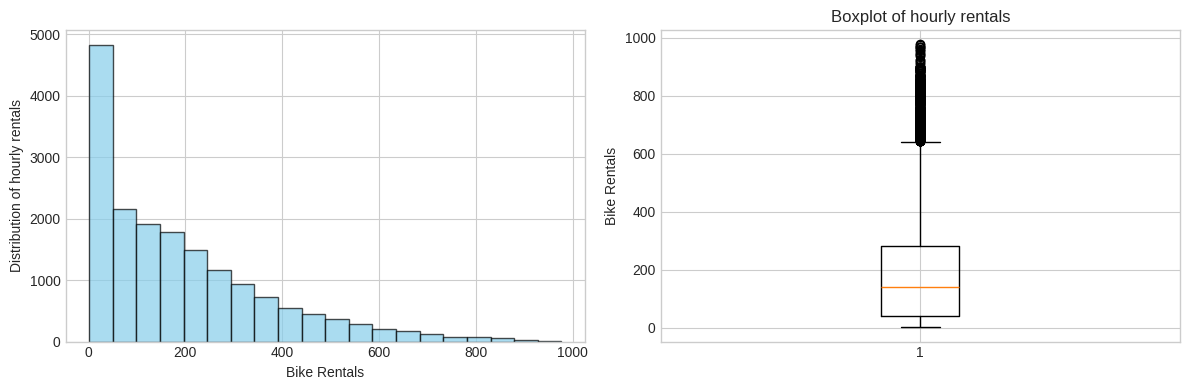

In [26]:
#Target variable
print(df['cnt'].describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['cnt'], bins=20, edgecolor='black', color='skyblue', alpha=0.7)
axes[0].set_xlabel('Bike Rentals')
axes[0].set_ylabel('Distribution of hourly rentals')

axes[1].boxplot(df['cnt'])
axes[1].set_ylabel("Bike Rentals")
axes[1].set_title('Boxplot of hourly rentals')

plt.tight_layout()
plt.show()

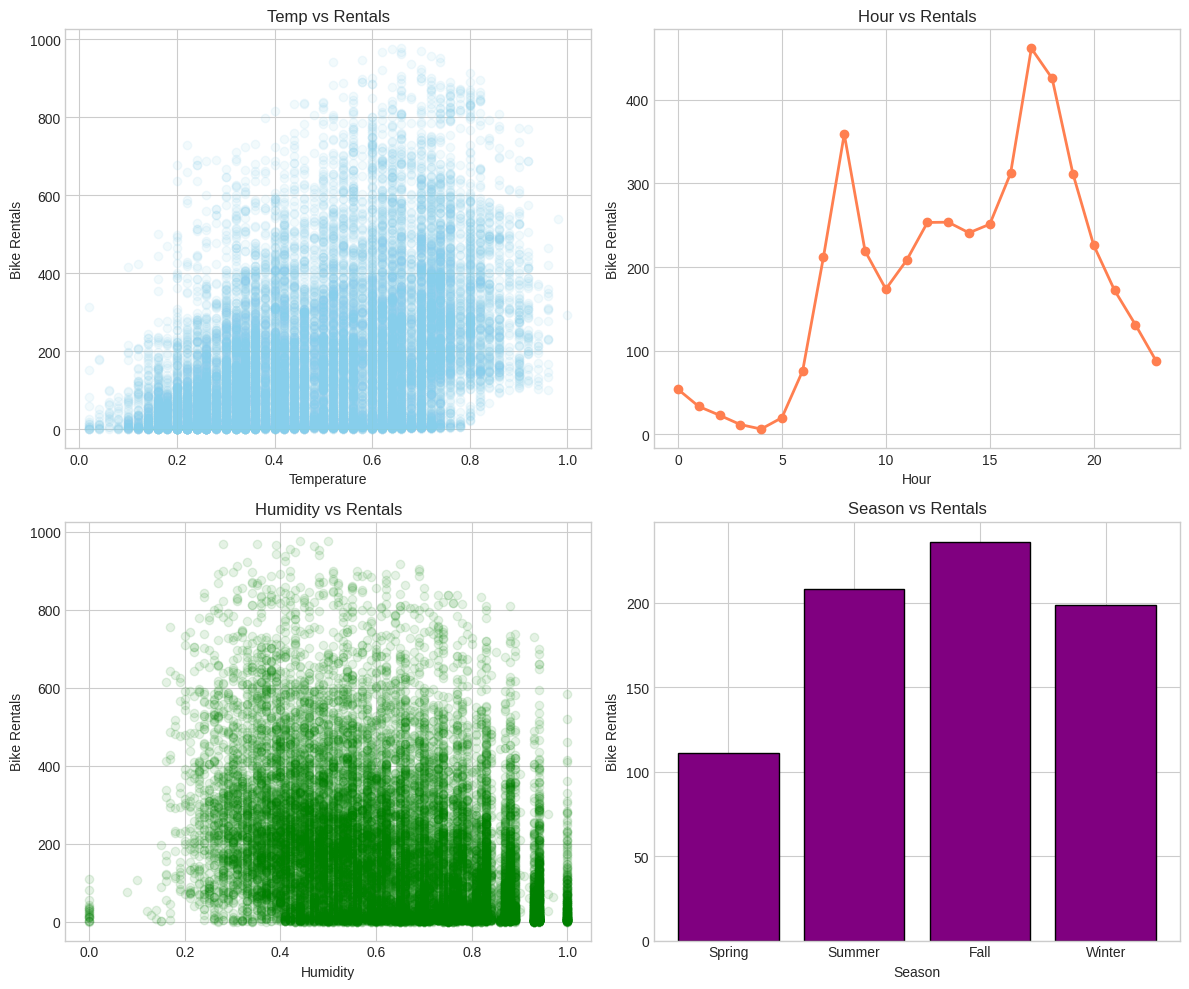

In [27]:
#key insight: Non-linear relationships with temp
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Temp vs Rentals
axes[0, 0].scatter(df['temp'], df['cnt'], alpha=0.1, color='skyblue')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Bike Rentals')
axes[0, 0].set_title("Temp vs Rentals")

# Hour vs Rentals
hourly_avg  = df.groupby('hr')['cnt'].mean()
axes[0, 1].plot(hourly_avg.index, hourly_avg.values, 'o-', color='coral', linewidth=2)
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Bike Rentals')
axes[0, 1].set_title("Hour vs Rentals")

# Humidity vs rentals
axes[1, 0].scatter(df['hum'], df['cnt'], alpha=0.1, color='green')
axes[1, 0].set_xlabel('Humidity')
axes[1, 0].set_ylabel('Bike Rentals')
axes[1, 0].set_title("Humidity vs Rentals")

#Season vs Rentals
season_avg = df.groupby('season')['cnt'].mean()
axes[1, 1].bar(['Spring', 'Summer', 'Fall', 'Winter'], season_avg.values, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Bike Rentals')
axes[1, 1].set_title("Season vs Rentals")

plt.tight_layout()
plt.show()

Prepare the data

In [28]:
feature_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
                'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
x = df[feature_cols]
y = df['cnt']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


print(f"Training set: {x_train.shape[0]:,} samples")
print(f"Test set: {x_test.shape[0]:,} samples")
print(f"Features: {x_train.shape[1]}")

Training set: 13,903 samples
Test set: 3,476 samples
Features: 12


In [29]:
#scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [30]:
#Baseline: Linear Regression
model_linear = LinearRegression()
model_linear.fit(x_train_scaled, y_train)

y_pred_linear_train = model_linear.predict(x_train_scaled)
y_pred_linear_model = model_linear.predict(x_test_scaled)

print(f"Train R2: {r2_score(y_train, y_pred_linear_train)}")
print(f"Test R2: {r2_score(y_test, y_pred_linear_model)}")
print(f"Train MSE: {mean_squared_error(y_train, y_pred_linear_train):.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_linear_model):.2f}")

Train R2: 0.3888110962633091
Test R2: 0.38798115831391333
Train MSE: 20292.65
Test MSE: 19379.83


In [31]:
#Polynomial Reg  - degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

print(f"Original featurea: {x_train_scaled.shape[1]}")
print(f"Polynomial features: {x_train_poly.shape[1]}")

Original featurea: 12
Polynomial features: 90


In [32]:
#Training Polynomial Model
model_poly = LinearRegression()
model_poly.fit(x_train_poly, y_train)

y_pred_poly_train = model_poly.predict(x_train_poly)
y_pred_poly_test = model_poly.predict(x_test_poly)

print(f"Train R2: {r2_score(y_train, y_pred_poly_train)}")
print(f"Test R2: {r2_score(y_test, y_pred_poly_test)}")
print(f"Train MSE: {mean_squared_error(y_train, y_pred_poly_train):.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_poly_test):.2f}")

Train R2: 0.5519781525766865
Test R2: 0.541977291904856
Train MSE: 14875.19
Test MSE: 14503.48


In [33]:
#Comparing different polynomial degrees
results = []

for degree in [1, 2, 3]:
  if degree == 1:
    x_tr, x_te = x_train_scaled, x_test_scaled
    n_features = x_train_scaled.shape[1]

  else:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    x_tr = poly.fit_transform(x_train_scaled)
    x_te = poly.transform(x_test_scaled)
    n_features = x_tr.shape[1]

  model = LinearRegression()
  model.fit(x_tr, y_train)

  results.append({
      'degree': degree,
      'n_features': n_features,
      'train_r2': r2_score(y_train, model.predict(x_tr)),
      'test_r2': r2_score(y_test, model.predict(x_te)),
      'train_mse': mean_squared_error(y_train, model.predict
                                      (x_tr)),
      'test_mse': mean_squared_error(y_test, model.predict(x_te))
  })

results_df = pd.DataFrame(results)
print(results_df.round(4).to_string(index=False))

 degree  n_features  train_r2  test_r2  train_mse   test_mse
      1          12    0.3888   0.3880 20292.6481 19379.8284
      2          90    0.5520   0.5420 14875.1877 14503.4775
      3         454    0.6464   0.6266 11740.7536 11825.3850


In [34]:
#Degree 3 has MUCH higher train R² but similar/worse test R²
#It is clear that the data is overfitting

The solution - Regularization

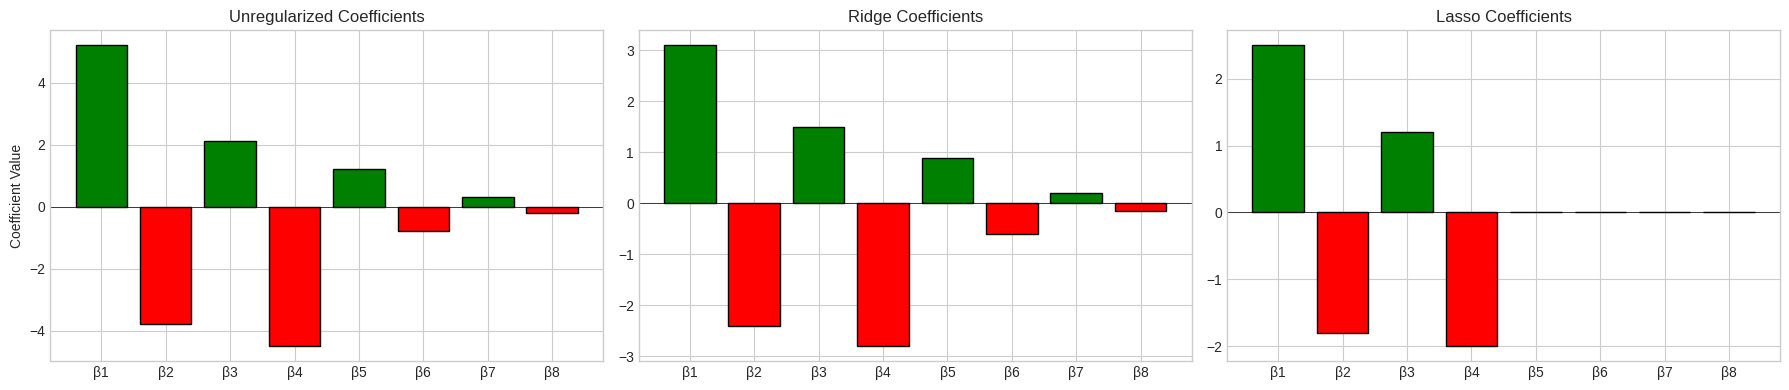

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

#Example coeffs
coef_unreg = [5.2, -3.8, 2.1, -4.5, 1.2, -0.8, 0.3, -0.2]
coef_ridge = [3.1, -2.4, 1.5, -2.8, 0.9, -0.6, 0.2, -0.15]
coef_lasso = [2.5, -1.8, 1.2, -2.0, 0, 0, 0, 0]

x = range(len(coef_unreg))
labels = [f'β{i}' for i in range(1, len(coef_unreg)+1)]

#unregularized
colors_unreg = ['green' if c > 0 else 'red' for c in coef_unreg]
axes[0].bar(x, coef_unreg, color=colors_unreg, edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_title("Unregularized Coefficients")
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_ylabel('Coefficient Value')

# Ridge
colors_ridge = ['green' if c > 0 else 'red' for c in coef_ridge]
axes[1].bar(x, coef_ridge, color=colors_ridge, edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_title("Ridge Coefficients")
axes[1].axhline(y=0, color='black', linewidth=0.5)

# Lasso
colors_lasso = ['green' if c > 0 else 'red' if c < 0 else 'gray' for c in coef_lasso]
axes[2].bar(x, coef_lasso, color=colors_lasso, edgecolor='black')
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels)
axes[2].set_title("Lasso Coefficients")
axes[2].axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

Ridge Regression (L2)

In [36]:
#use polynomial features for regularization comparison
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

print(f"Polynomial features: {x_train_poly.shape[1]}")

#trying different alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(x_train_poly, y_train)

  train_r2 = r2_score(y_train, ridge.predict(x_train_poly))
  test_r2 = r2_score(y_test, ridge.predict(x_test_poly))

  print(f"a = {alpha:<8} | Train r2 = {train_r2:.4f} | Test r2 = {test_r2:.4f}")


Polynomial features: 90
a = 0.001    | Train r2 = 0.5520 | Test r2 = 0.5420
a = 0.01     | Train r2 = 0.5520 | Test r2 = 0.5420
a = 0.1      | Train r2 = 0.5520 | Test r2 = 0.5420
a = 1        | Train r2 = 0.5520 | Test r2 = 0.5420
a = 10       | Train r2 = 0.5520 | Test r2 = 0.5420
a = 100      | Train r2 = 0.5516 | Test r2 = 0.5417
a = 1000     | Train r2 = 0.5486 | Test r2 = 0.5403


In [37]:
#Finding optimal alpha
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge_cv.fit(x_train_poly, y_train)

print(f"Optimal alpha: {ridge_cv.alpha_:.4f}")
print(f"R^2 score: {ridge_cv.score(x_test_poly, y_test):.4f}")
print(f"Number of features used: {np.sum(ridge_cv.coef_ != 0)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_cv.predict(x_test_poly))):.2f}")

Optimal alpha: 70.5480
R^2 score: 0.5418
Number of features used: 90
Test RMSE: 120.46


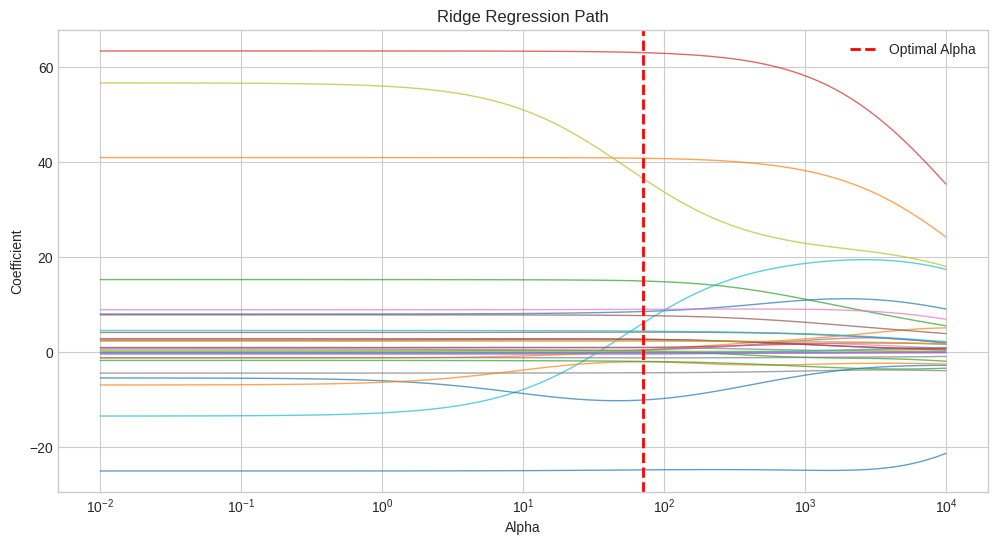

In [38]:
#Visualizinf Ridge Path
alphas_path = np.logspace(-2, 4, 100)
coefs = []

for alpha in alphas_path:
  ridge = Ridge(alpha=alpha)
  ridge.fit(x_train_poly, y_train)
  coefs.append(ridge.coef_)

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(min(30, coefs.shape[1])):
  ax.plot(alphas_path, coefs[:, i], linewidth=1, alpha=0.7)

ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('Coefficient')
ax.set_title('Ridge Regression Path')
ax.axvline(x=ridge_cv.alpha_, color='red', linestyle='--', linewidth=2, label='Optimal Alpha')
ax.legend()
plt.show()


Lasso regression

In [39]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(x_train_poly, y_train)

  train_r2 = r2_score(y_train, lasso.predict(x_train_poly))
  test_r2 = r2_score(y_test, lasso.predict(x_test_poly))
  n_nonzero = np.sum(lasso.coef_ != 0)

  print(f"a = {alpha:<8} | Train r2 = {train_r2:.4f} | Test r2: {test_r2:.4f} | Nonzero Coeffs: {n_nonzero}")


a = 0.001    | Train r2 = 0.5520 | Test r2: 0.5420 | Nonzero Coeffs: 88
a = 0.01     | Train r2 = 0.5520 | Test r2: 0.5420 | Nonzero Coeffs: 84
a = 0.1      | Train r2 = 0.5515 | Test r2: 0.5417 | Nonzero Coeffs: 69
a = 1        | Train r2 = 0.5489 | Test r2: 0.5408 | Nonzero Coeffs: 46
a = 10       | Train r2 = 0.4970 | Test r2: 0.4966 | Nonzero Coeffs: 17
a = 100      | Train r2 = 0.0000 | Test r2: -0.0010 | Nonzero Coeffs: 0


In [40]:
#Finding the optimal alpha
lasso_cv = LassoCV(alphas=np.logspace(-3, 2, 100), cv=5, max_iter=10000)
lasso_cv.fit(x_train_poly,  y_train)

print(f"Optimal alpha: {lasso_cv.alpha_:.4f}")
print(f"Train r2 score: {lasso_cv.score(x_train_poly, y_train):.4f}")
print(f"Test r2 score: {lasso_cv.score(x_test_poly, y_test):.4f}")
print(f"Number of features used: {np.sum(lasso_cv.coef_ != 0)}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, lasso_cv.predict(x_test_poly))):.2f}")

Optimal alpha: 0.2656
Train r2 score: 0.5512
Test r2 score: 0.5416
Number of features used: 63
Test RMSE: 120.48


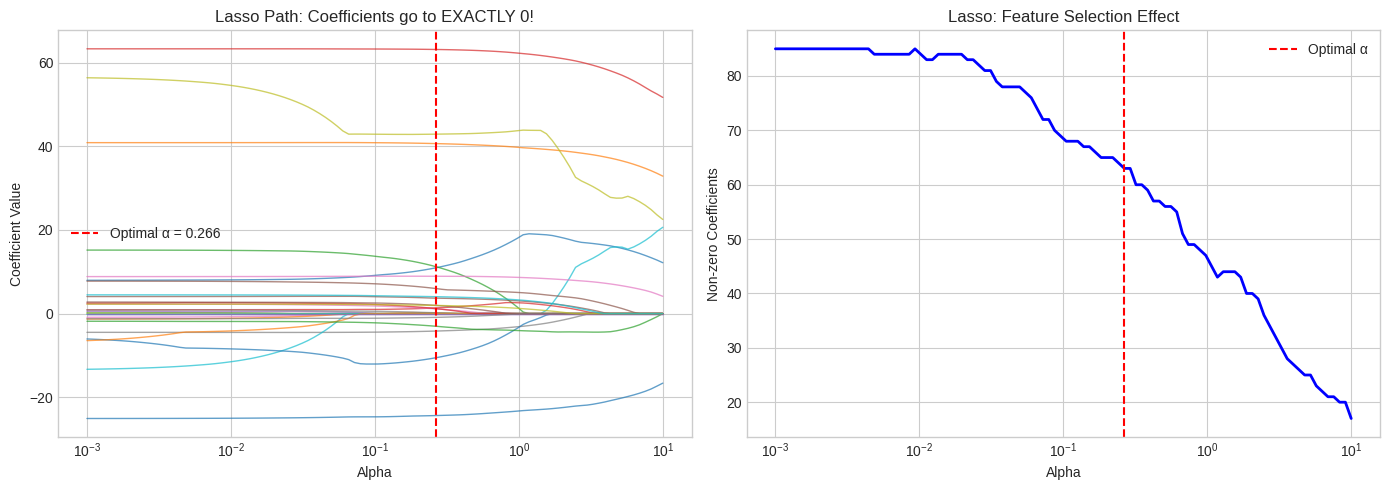

In [41]:
# Visualize Lasso path
alphas_path = np.logspace(-3, 1, 100)
coefs = []
n_nonzero = []

for alpha in alphas_path:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(x_train_poly, y_train)
    coefs.append(lasso.coef_)
    n_nonzero.append(np.sum(lasso.coef_ != 0))

coefs = np.array(coefs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Coefficient path
for i in range(min(30, coefs.shape[1])):
    axes[0].plot(alphas_path, coefs[:, i], linewidth=1, alpha=0.7)

axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Coefficient Value')
axes[0].set_title('Lasso Path: Coefficients go to EXACTLY 0!')
axes[0].axvline(x=lasso_cv.alpha_, color='red', linestyle='--', label=f'Optimal α = {lasso_cv.alpha_:.3f}')
axes[0].legend()

# Number of non-zero coefficients
axes[1].plot(alphas_path, n_nonzero, 'b-', linewidth=2)
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Non-zero Coefficients')
axes[1].set_title('Lasso: Feature Selection Effect')
axes[1].axvline(x=lasso_cv.alpha_, color='red', linestyle='--', label=f'Optimal α')
axes[1].legend()

plt.tight_layout()
plt.show()

In [42]:
# Which features did Lasso select?
feature_names = poly.get_feature_names_out(feature_cols)

lasso_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_cv.coef_
})

# Non-zero coefficients
selected = lasso_coef_df[lasso_coef_df['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)

print(f"Lasso selected {len(selected)} out of {len(feature_names)} features:")
print("="*60)
print(selected.head(20).to_string(index=False))

Lasso selected 63 out of 90 features:
         Feature  Coefficient
            hr^2   -68.462336
              hr    63.161170
            temp    42.912801
              yr    40.654110
         hr temp    25.166159
             hum   -24.381353
  workingday hum    17.472675
          temp^2   -17.231754
      mnth atemp    16.720866
          hr hum   -12.028859
            mnth    11.222594
          season    10.951644
workingday atemp   -10.855364
     season temp   -10.557116
        yr atemp     9.261551
   hr workingday     9.191911
           yr hr     8.926666
          yr hum    -8.847853
        temp hum    -7.928018
           hum^2    -6.894217


Elastic Net (L1 + L2)

In [46]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

for l1 in l1_ratios:
  en = ElasticNet(alpha=0.1, l1_ratio=l1, max_iter=10000)
  en.fit(x_train_poly, y_train)

  test_r2 = r2_score(y_test, en.predict(x_test_poly))
  n_nonzero = np.sum(en.coef_ != 0)

  print(f"l1_ratio = {l1} | Test r2 = {test_r2:.4f}, | Non-zero: {n_nonzero}")

l1_ratio = 0.1 | Test r2 = 0.5396, | Non-zero: 89
l1_ratio = 0.3 | Test r2 = 0.5404, | Non-zero: 85
l1_ratio = 0.5 | Test r2 = 0.5410, | Non-zero: 81
l1_ratio = 0.7 | Test r2 = 0.5413, | Non-zero: 76
l1_ratio = 0.9 | Test r2 = 0.5415, | Non-zero: 78


In [47]:
#Finding optimal ElasticNet parameters
elastic_cv = ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99],
                          alphas=np.logspace(-3, 1, 50),
                          cv=5, max_iter=10000)
elastic_cv.fit(x_train_poly, y_train)

print(f"OPtimal Elastic Net:")
print(f"Alpha: {elastic_cv.alpha_:.4f}")
print(f"L1 Ratio: {elastic_cv.l1_ratio_:.2f}")
print(f"Train r2: {r2_score(y_train, elastic_cv.predict(x_train_poly)):.4f}")
print(f"Test r2: {r2_score(y_test, elastic_cv.predict(x_test_poly)):.4f}")
print(f"Non-zero Coeffs: {np.sum(elastic_cv.coef_ != 0)}")

OPtimal Elastic Net:
Alpha: 0.1931
L1 Ratio: 0.99
Train r2: 0.5513
Test r2: 0.5416
Non-zero Coeffs: 66


Final Comparison

In [49]:
# Compare all models
models = {
    'Linear (No Poly)': LinearRegression().fit(x_train_scaled, y_train),
    'Linear (Poly)': LinearRegression().fit(x_train_poly, y_train),
    'Ridge': ridge_cv,
    'Lasso': lasso_cv,
    'Elastic Net': elastic_cv
}

comparison = []

for name, model in models.items():
  if name == 'Linear (No Poly)':
    x_tr, x_te = x_train_scaled, x_test_scaled
    n_features = x_train_scaled.shape[1]

  else:
    x_tr, x_te = x_train_poly, x_test_poly
    n_features = x_train_poly.shape[1]

  y_pred_train = model.predict(x_tr)
  y_pred_test = model.predict(x_te)

  if hasattr(model, 'coef_'):
    n_nonzero = np.sum(model.coef_ != 0)
  else:
    n_nonzero = n_features

  comparison.append({
      'Model': name,
      'Train R²': r2_score(y_train, y_pred_train),
      'Test R²': r2_score(y_test, y_pred_test),
      'Test RMSE': np.sqrt(mean_squared_error(y_test,  y_pred_test)),
      'Features Used': n_nonzero
  })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.round(4).to_string(index=False))

           Model  Train R²  Test R²  Test RMSE  Features Used
Linear (No Poly)    0.3888   0.3880   139.2115             12
   Linear (Poly)    0.5520   0.5420   120.4304             90
           Ridge    0.5517   0.5418   120.4587             90
           Lasso    0.5512   0.5416   120.4769             63
     Elastic Net    0.5513   0.5416   120.4766             66


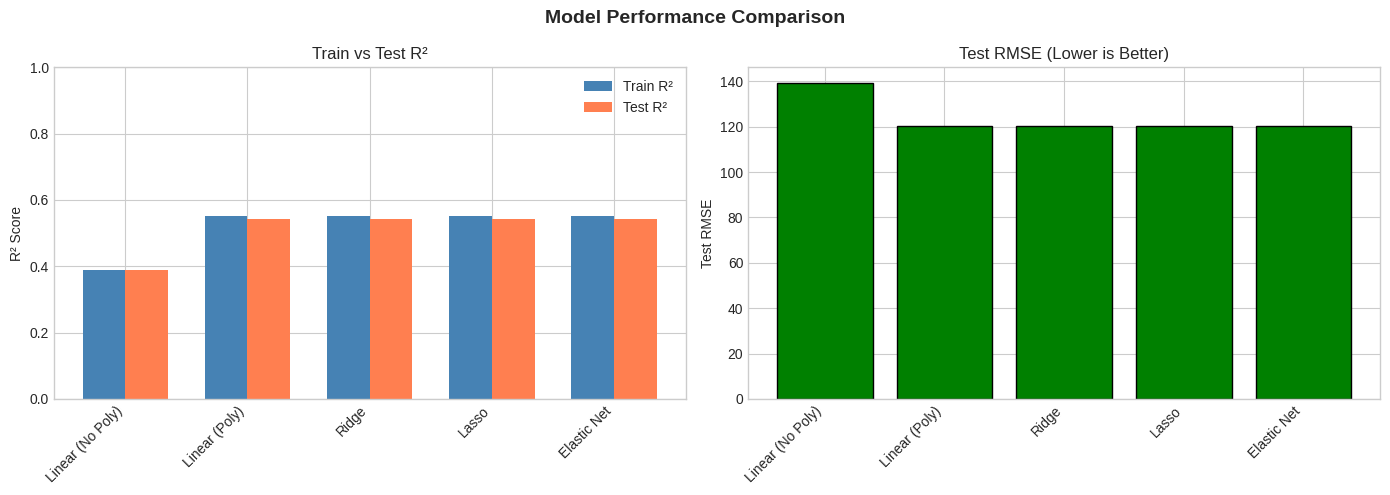

In [50]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
x = range(len(comparison_df))
width = 0.35

axes[0].bar([i - width/2 for i in x], comparison_df['Train R²'], width, label='Train R²', color='steelblue')
axes[0].bar([i + width/2 for i in x], comparison_df['Test R²'], width, label='Test R²', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Train vs Test R²')
axes[0].legend()
axes[0].set_ylim(0, 1)

# RMSE Comparison
axes[1].bar(x, comparison_df['Test RMSE'], color='green', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('Test RMSE')
axes[1].set_title('Test RMSE (Lower is Better)')

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [51]:
#%%
print("="*70)
print("              WHEN TO USE WHICH REGULARIZATION?")
print("="*70)

print("""
┌─────────────────┬────────────────────────────────────────────────┐
│ Method          │ Use When...                                    │
├─────────────────┼────────────────────────────────────────────────┤
│ Linear          │ Few features, linear relationships             │
│ (no regularization)                                              │
├─────────────────┼────────────────────────────────────────────────┤
│ Polynomial      │ Clear non-linear patterns, few features        │
│ (no regularization)                                              │
├─────────────────┼────────────────────────────────────────────────┤
│ Ridge (L2)      │ Many correlated features                       │
│                 │ Want to keep ALL features (just shrink them)   │
│                 │ Multicollinearity is a problem                 │
├─────────────────┼────────────────────────────────────────────────┤
│ Lasso (L1)      │ Want automatic feature selection               │
│                 │ Suspect many features are irrelevant           │
│                 │ Want interpretable sparse model                │
├─────────────────┼────────────────────────────────────────────────┤
│ Elastic Net     │ Many features, some correlated                 │
│                 │ Want BOTH shrinkage AND selection              │
│                 │ More features than samples (p > n)             │
└─────────────────┴────────────────────────────────────────────────┘
""")

              WHEN TO USE WHICH REGULARIZATION?

┌─────────────────┬────────────────────────────────────────────────┐
│ Method          │ Use When...                                    │
├─────────────────┼────────────────────────────────────────────────┤
│ Linear          │ Few features, linear relationships             │
│ (no regularization)                                              │
├─────────────────┼────────────────────────────────────────────────┤
│ Polynomial      │ Clear non-linear patterns, few features        │
│ (no regularization)                                              │
├─────────────────┼────────────────────────────────────────────────┤
│ Ridge (L2)      │ Many correlated features                       │
│                 │ Want to keep ALL features (just shrink them)   │
│                 │ Multicollinearity is a problem                 │
├─────────────────┼────────────────────────────────────────────────┤
│ Lasso (L1)      │ Want automatic feature selection  